# Create and Find Images with Stable Diffusion

Welcome to our notebook on Synthetic Image Creation and Search. In this notebook, we'll guide you through a comprehensive demonstration of clustering and searching for images semantically, using embeddings derived from the Florence Foundation model. The techniques presented here are incredibly versatile and can be applied in the following ways:

To discover or group images by visual similarity, enabling intuitive organization and retrieval of visual data.
To locate specific images using a text description, a feature particularly beneficial when dealing with large image databases.
To exemplify these applications, we're utilizing images from three distinct categories: 1) Female Individuals, 2) Male Individuals, and 3) Animals.

If you have your own collection of images representing different classes similar to the examples above, these can be organized in subfolders within the `./source` directory. It is recommended that the names of these subfolders accurately reflect the nature of the classes they represent.

However, if you're starting without a pre-existing set of images, don't fret! The first section of this notebook is dedicated to guiding you through the process of creating synthetic images using the Stable Diffusion technique. By the end of this notebook, you will not only have a collection of synthetic images but also the ability to effectively manage and search through them using the power of the Florence Foundation model.

Since we are going to mount an internal snowflake stage as a volume, we will build our entire solution and load the generated synthetic images directly on the snowflake internal named stage "model_stage_matting". Towards the end, we load the images metadata to a snowflake table which will be used by cortex search to build the embeddings and index in the background.

Finally, we use streamlit in snowflake to perform image similarity using the cortex search service we enabled on snowflake table.

## General Imports and Helper Functions

In [1]:
import sys
sys.path.insert(0, '..')

import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
import requests
from io import BytesIO

#from utils import show_images

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

In [2]:
def show_images(images, cols=2, source='url', savedir='', show_title=False, titles=None):
    """
    Get images from URL and display them in a grid. Optionally save or retrieve images to/from local dir. 
    
    Parameters
    ----------
    images : list
        List of image urls or local file paths.
    cols : int
        Number of columns in the grid.
    source : str
        'url' or 'local'
    savedir : str
        Directory to save images to.
    show_title : bool
        Display filename as image title (local files only)
    """
    
    if savedir != '':
        os.makedirs(savedir, exist_ok=True)
        
    rows = int(math.ceil(len(images) / cols))

    fig = plt.figure(figsize=(cols * 5, rows * 5)) # specifying the overall grid size. TODO: 7,5 for landscape images

    for i, image_url in enumerate(images):
        plt.subplot(rows, cols,i+1)  
        
        if source == 'url':
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            # save images if savedir is specified
            if savedir != '':
                
                # get list of png files
                png_filenames = [image for image in os.listdir(savedir) if image.endswith('.png')]
                # get highest index from existing files
                if png_filenames == []:
                    max_index = 0
                else:
                    max_index = max([int(filename.strip('.png')) for filename in png_filenames])

                # save new file with index + 1
                new_filename = f'{max_index+1:03d}.png'
                fp = os.path.join(savedir, new_filename)
                img.save(fp, 'PNG')            
            
        else: 
            img = Image.open(image_url) # local file
            if show_title:
                if titles is None: plt.title(image_url)
                else: plt.title(titles[i])


        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()

    plt.show()


# Part I: Create Synthetic Images of Men, Women and Animals
__Note:__ This is an optional step if you don't want to bring your own sample images.

In [3]:
from diffusers import StableDiffusionPipeline, AutoencoderKL,  DPMSolverMultistepScheduler
import torch
import random
from IPython.display import display

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# Central variables for image generation:

classes = ['man', 'woman', 'animal'] # classes to generate 
root = '/app/imagesimilarity/genimages' # root folder for generated images
images_per_class = 100

Feel free to experiment with different models like `Realistic Vision 2.0` or `Stable Diffusion 2.1`. We have generated images of individuals using the Realistic Vision model. For animals, we have chosen Stable Diffusion 2.1.

In [5]:
# for using Realistic Vision 2.0
# pipe = StableDiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V2.0",
#                                                torch_dtype=torch.float16,
#                                                )


# for using Stable Diffusuin 2.1
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                              # torch_dtype=torch.float16,
                                               )

pipe.to('cuda')

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "stabilityai/stable-diffusion-2-1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
%%capture
def generate_prompt(classname):

    shot = random.choice(['Long shot', 'Full shot', 'Medium shot', 'Close up'])
    medium = random.choice(['raw photo'])
    age = random.choice(['young', 'middle aged', 'senior']) 
    origin = random.choice(['German', 'European', 'English', 'Spanish', 'American', 'African', 'Asian'])
    dressed = random.choice(['casually', 'business formally', 'black tied'])
    male_role = random.choice(['businessman', 'male tourist', 'man']) 
    female_role = random.choice(['businesswoman', 'female tourist', 'woman']) 
    doing = random.choice(['walking in a busy city', 'in a business meeting', 'eating in a restaurant', 'talking to coworkers', 'bicycling', 'driving a a convertible', 'walking in a park'])
    animal_scene = random.choice([
        'lion running in the steppe', 
        'eagle flying in the sky',
        'dolphins leaping in the ocean',
        'a herd of elephants marching through the savannah',
        'monkeys swinging through the rainforest',
        'penguins waddling on the Antarctic ice',
        'a kangaroo hopping in the Australian outback',
        'a polar bear hunting in the Arctic',
        'a snake slithering in the desert',
        'a group of ants marching in the forest',
        'a deer grazing in the meadow',
        'a colony of bats flying out of a cave',
        'a wolf pack howling at the moon in the tundra',
        'a tortoise slowly walking on a sunny beach',
        'a squirrel darting up a tree in the park',
        'an octopus swimming in the deep sea',
        'a butterfly fluttering in a blooming garden'
    ])

    if classname == 'man':
        prompt = f'{shot} {medium} of {age} {dressed} dressed {origin} {male_role} {doing}'
    if classname == 'woman':
        prompt = f'{shot} {medium} of {age} {dressed} dressed {origin} {female_role} {doing}'
    if classname == 'animal':
        prompt = f'{shot} {medium} of {animal_scene}'

    return prompt

def generate_images(prompt, num_images=1):

    suffix = ", (high detailed skin:1.2), 8k uhd, dslr, high quality, film grain, real-world, unedited, photorealistic, Fujifilm XT3, natural, authentic"
    negative_prompt = '(semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck'

    images = pipe(prompt=prompt + suffix,
                negative_prompt=negative_prompt,
                height=512,
                width=768,
                guidance_scale=7.5,
                num_inference_steps=50,
                num_images_per_prompt=num_images,
                ).images
    
    return images

import pandas as pd
columns = ['Prompt','Classname','Image_name','Source_Image_path']
img_table_df = pd.DataFrame(columns=columns)

for classname in classes:
    image_path = os.path.join(root, classname)
    # create the directory if it doesn't exist
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    lim = 0
    if lim>5:
        break
    else:
        for image_idx in range(images_per_class):
            prompt = generate_prompt(classname)
            # print(prompt)
            image = generate_images(prompt)[0]
            file_name = prompt.replace(' ','_')
            rand_num = random.randint(100000, 999999)
            new_row = {"Prompt": prompt, \
                       "classname": classname,\
                       "Image_name":f"image-{file_name}.png",\
                       "Source_Image_path":os.path.join(image_path, f"image-{file_name}.png")
                      }
            img_table_df = pd.concat([img_table_df, pd.DataFrame([new_row])],ignore_index=True,axis=0)
            image.save(os.path.join(image_path, f"image-{file_name}.png"))
            lim+=1

## Review Samples of generated Images

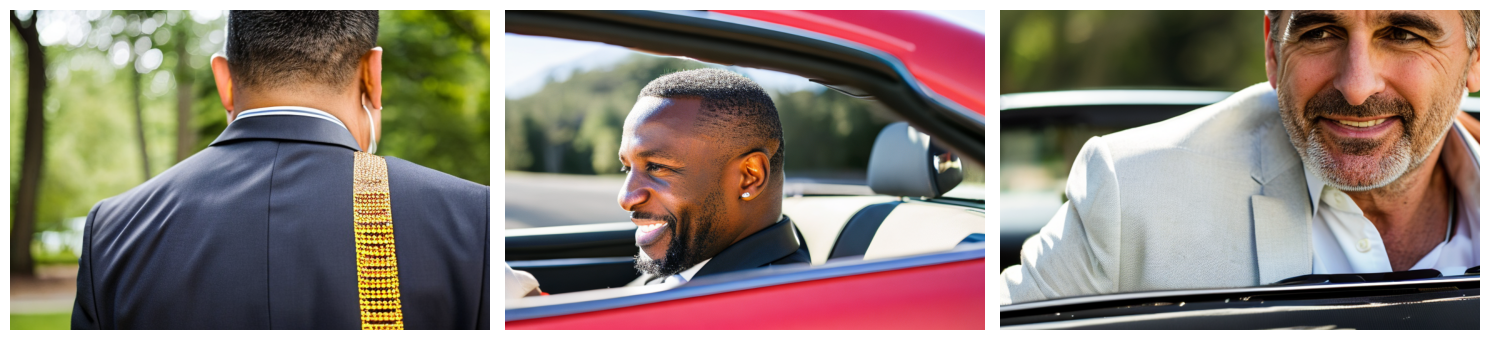

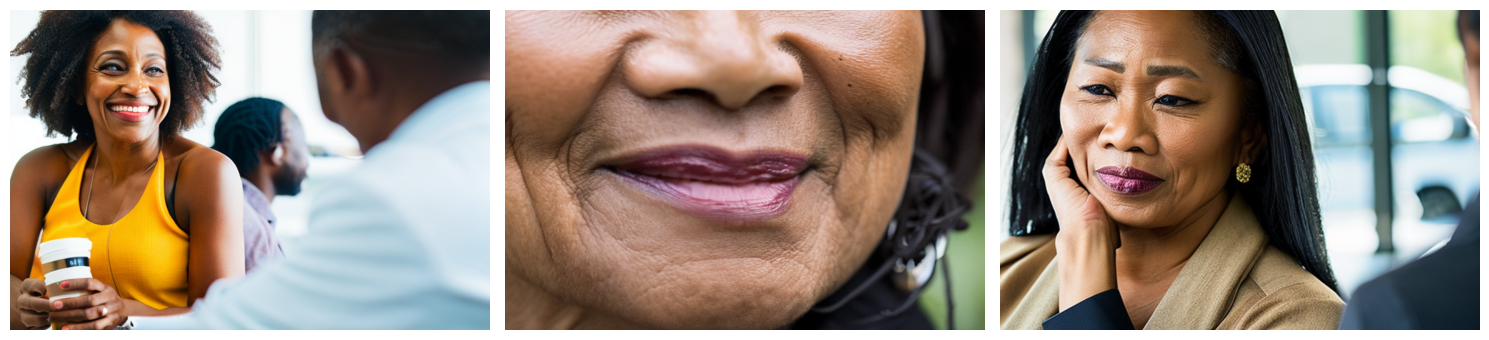

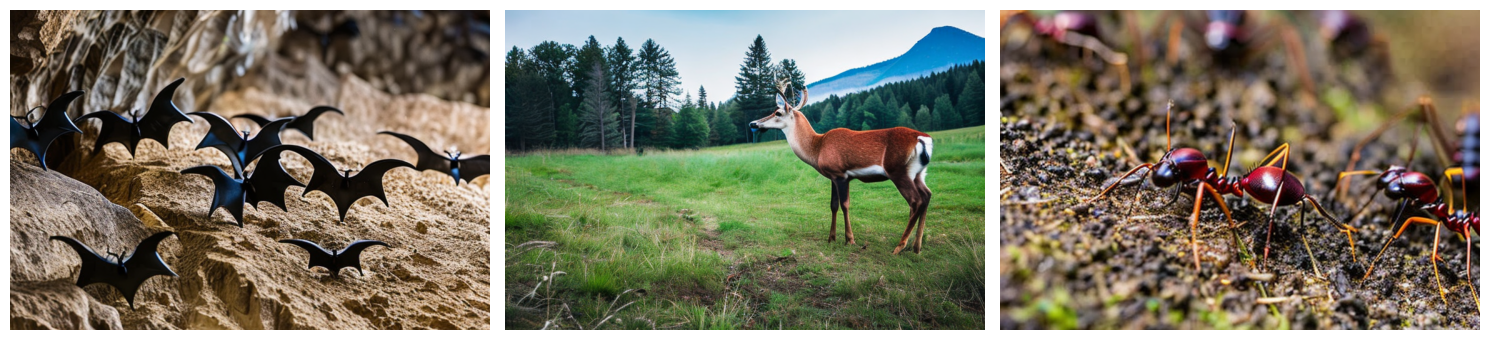

In [9]:
samples_per_class = 3

for classname in classes:
    image_path = os.path.join(root, classname)
    image_list = [os.path.join(image_path, image) for image in os.listdir(image_path) if image.endswith('.png')]

    show_images(images=image_list[:samples_per_class], cols=3, source='local')

# Write metadata on the image and save again

In [15]:
def write_metadata(image, prompt, classname):
    from exif import Image
    from PIL import Image, PngImagePlugin
    
    folder_path = '/app/imagesimilarity/genimages/'+classname+'/'
    img_filename = image
    img_path = f'{folder_path}/{img_filename}'
    
    import imageio
    height, width, channels = imageio.imread(img_path).shape
    
    #path to image file
    file = image
    
    #create the metadata object
    pngMetaData = PngImagePlugin.PngInfo()
    
    #add the data
    pngMetaData.add_text('height',str(height))
    pngMetaData.add_text('width',str(width))
    pngMetaData.add_text('Description',prompt)
    if classname == 'man':
        pngMetaData.add_text('Camera','Canon')
    if classname == 'woman':
        pngMetaData.add_text('Camera','Samsung')
    if classname == 'animal':
        pngMetaData.add_text('Camera','Nokia')
    pngMetaData.add_text('artist',classname)
    pngMetaData.add_text('copyright','KNadadur 2025')
    #open the image file and save the metadata
    with Image.open(img_path) as image_file:
        image_file.save(img_path, pnginfo=pngMetaData)
        
def confirm_metadata(image, classname):
    from PIL import Image, PngImagePlugin
    folder_path = '/app/imagesimilarity/genimages/'+classname+'/'
    img_filename = image
    img_path = f'{folder_path}/{img_filename}'

    targetImage = Image.open(img_path)

In [16]:
for index, row in img_table_df.iterrows():
    image = row['Image_name']
    prompt = row['Prompt']
    classname = row['classname']
    write_metadata(image, prompt, classname)
    confirm_metadata(image, classname)

/tmp/ipykernel_130/4087832028.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(img_path).shape


In [17]:
img_table_df_copy = img_table_df.copy()
img_table_df_copy.index+=1

In [18]:
from PIL import Image, PngImagePlugin
new_df = pd.DataFrame(columns=["ImageMetadata"])
for index, row in img_table_df_copy.iterrows():
    img_path = row['Source_Image_path']
    targetImage = Image.open(img_path)
    new_df=pd.concat([new_df,pd.DataFrame({"ImageMetadata":targetImage.text})],ignore_index=True,axis=1)
new_df = new_df.T.dropna()

In [19]:
img_table_df_final = pd.concat([img_table_df_copy,new_df],ignore_index=False,axis=1)

In [20]:
img_table_df_final.rename(columns={"Description":"chunk","classname":"category"},inplace=True)
img_table_df_final.drop(columns={"Prompt","Classname"},inplace=True)

# Snowpark related

In [21]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, max as _max
import json
import pandas as pd

In [23]:
with open('/app/imagesimilarity/creds.json') as f:
    data = json.load(f)
    USERNAME = data['username']
    PASSWORD = data['password']
    ROLE = data['role']
    ACCOUNT = data['account']
    WAREHOUSE = data['warehouse']
    DATABASE = data['database']
    SCHEMA = data['schema']

CONNECTION_PARAMETERS = {
   "account": ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
   "role": ROLE, 
   "database": DATABASE,
   "warehouse": WAREHOUSE,
   "schema": SCHEMA
}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()
session.get_current_warehouse()

'"XS_WH"'

In [25]:
table_name = "images_prompts_table"

In [26]:
session.write_pandas(img_table_df_final,table_name,auto_create_table=True, table_type="transient",overwrite=True)

/root/miniconda3/envs/myenv/lib/python3.9/site-packages/snowflake/snowpark/session.py:2425: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.range.RangeIndex'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, _, _, ci_output = write_pandas(


# Create Cortex Search Service on the table

In [1]:
cortex_search = '''create or replace CORTEX SEARCH SERVICE D_SEARCH_SERVICE_CS_2
ON chunk
ATTRIBUTES category,
relative_path
warehouse = XS_WH
TARGET_LAG = '1 minute'
as (
select  
"chunk" as chunk,
"category" as category,
replace("Source_Image_path",'/app/imagesimilarity/','') as relative_path
from
"images_prompts_table"
where 
"chunk" is not null and
"category" is not null and
"Source_Image_path" is not null
)'''

session.sql(cortex_search).collect()

# Now you create streamlit in snowflake app by copying and pasting the python code below. Replace the CORTEX_SEARCH_DATABASE and CORTEX_SEARCH_SCHEMA based on yours.

In [ ]:
'''
import streamlit as st # Import python packages
from snowflake.snowpark.context import get_active_session

from snowflake.core import Root

import pandas as pd
import json

pd.set_option("max_colwidth",None)

### Default Values
NUM_CHUNKS = 3 # Num-chunks provided as context. Play with this to check how it affects your accuracy

# service parameters
CORTEX_SEARCH_DATABASE = "SF_DATABASE"
CORTEX_SEARCH_SCHEMA = "SF_SCHEMA"
CORTEX_SEARCH_SERVICE = "D_SEARCH_SERVICE_CS"
######
######

# columns to query in the service
COLUMNS = [
    "chunk",
    "relative_path",
    "category"
]

session = get_active_session()
root = Root(session)                         

svc = root.databases[CORTEX_SEARCH_DATABASE].schemas[CORTEX_SEARCH_SCHEMA].cortex_search_services[CORTEX_SEARCH_SERVICE]
   
### Functions
     
def config_options():

    categories = session.sql('select "category" from "images_prompts_table"  where "category" is not null group by "category"').collect()

    cat_list = ['ALL']
    for cat in categories:
        cat_list.append(cat.category)
            
    st.sidebar.selectbox('Select what products you are looking for', cat_list, key = "category_value")

    st.sidebar.expander("Session State").write(st.session_state)

def get_similar_chunks_search_service(query):

    if st.session_state.category_value == "ALL":
        response = svc.search(query, COLUMNS, limit=NUM_CHUNKS)
    else: 
        filter_obj = {"@eq": {"category": st.session_state.category_value} }
        response = svc.search(query, COLUMNS, filter=filter_obj, limit=NUM_CHUNKS)

    st.sidebar.json(response.json())
    
    return response

def create_prompt (myquestion):
    prompt = f"""[0]
     'Question:  
       {myquestion} 
       Answer: '
       """
    relative_paths = "None"
            
    return prompt, relative_paths

def complete(myquestion):

    prompt, relative_paths =create_prompt (myquestion)
    cmd = """
            select snowflake.cortex.complete(?, ?) as response
          """
    
    df_response = session.sql(cmd, params=[st.session_state.model_name, prompt]).collect()
    return df_response, relative_paths

def main():
    
    st.title(f": Prompt to find similar images")
    st.write("This is the list of images that are similar the your prompt questions:")

    config_options()

    # st.session_state.rag = st.sidebar.checkbox('Use your own documents as context?')

    question = st.text_input("Enter question", placeholder="young businessman", label_visibility="collapsed")

    if question:
        response = get_similar_chunks_search_service(question)
        for idx in range(0,len(response.results)):
            st.write('      ')
            st.write(response.results[idx]["chunk"])
            path = response.results[idx]["relative_path"]
            cmd2 = f"select GET_PRESIGNED_URL(@model_stage_similarity, '{path}', 360) as URL_LINK from directory(@model_stage_similarity)"
            df_url_link = session.sql(cmd2).to_pandas()
            url_link = df_url_link._get_value(0,'URL_LINK')
            display_url = f"Image: [{path}]({url_link})"
            st.image(url_link)
                
if __name__ == "__main__":
    main()
'''